<a href="https://colab.research.google.com/github/dymochro/MOCHA/blob/main/MOCHA_ColabNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOCHA-FRAP
MOCHA-FRAP is a quantitative half-FRAP approach to assess if molecules in a structure of interest undergo liquid-liquid phase separation (LLPS) driven by multivalent interactions, or if they undergo low-valency interactions with spatially clustered binding sites (ICBS) on an immobile scaffold. MOCHA-FRAP distinguishes both models by quantifying the apparent energy barrier at the interface of the structure of interest. The theoretical and experimental background can be found in [link to the paper].

**Before performing half-FRAP experiments, check Supplementary Note 2 in [link to the paper] for advice on how to perform experiments that are suitable for the workflow described here.**

**This Colab Notebook is intended to provide a user-friendly interface to quantitatively analyze half-FRAP data. It consists of two parts:**
- **Analysis of individual experiments:** *Allows you to segment the nucleus/cytoplasm and the bleached structure of interest in an image stack, to retrieve the raw intensity traces, and to perform the corresponding normalization. The results can then be downloaded as .csv file.*
- **Analysis of dataset with normalized curves:** *Allows you to upload the .csv files generated in the previous step, to plot the average curve, to determine the dip depth in the non-bleached half, and to decide if the bleached protein undergoes LLPS or ICBS.*


## **Part I: Analysis of individual experiments**

In [21]:
#@title Import functions { run: "auto", display-mode: "form" }
#@markdown *Click on the arrow to import the functions that are required for the analysis.* 
# import all necesary packages
import matplotlib.pyplot as plt
from skimage.io import imread
import scipy.ndimage as ndi
from scipy.stats import ttest_ind_from_stats
from skimage.filters.thresholding import threshold_otsu
from skimage.measure import regionprops
from scipy import signal
from decimal import Decimal
import numpy as np
import copy
import os
from google.colab import files
%matplotlib inline

# define experiment class

class experiment:
  def __init__(self,path,time_res,pixel_res,nbleach,sigma):
    self.file_name = path
    self.img = imread(self.file_name)
    self.nframes = np.shape(self.img)[0]
    self.time_res,self.pixel_res,self.nbleach = time_res,pixel_res,(nbleach-1)
    self.bleach_img = ndi.filters.gaussian_filter(self.img[self.nbleach,:,:],sigma)
    self.prebleach_img = ndi.filters.gaussian_filter(self.img[(self.nbleach-1),:,:],sigma)
  
  def segment_cell(self,thr_nuc=0.1,nucsize_min=200,nucsize_max=20000000):
    thresh = threshold_otsu(self.prebleach_img)*thr_nuc
    self.nucmask = self.prebleach_img > thresh
    self.nucmask = ndi.binary_fill_holes(self.nucmask)
    self.nucmask = ndi.binary_closing(self.nucmask)
    self.nucmask = ndi.label(self.nucmask)[0]
    sizes = [(self.nucmask == x).sum() for x in np.unique(self.nucmask)[1:]]
    for id,size in zip(np.unique(self.nucmask)[1:],sizes):
      if size != np.max(sizes):
        self.nucmask[self.nucmask==id] = 0
    
  def segment_condensate(self,thr_cond=1.2,condsize_min=10,condsize_max=10000):
    self.prebleach_img[self.nucmask == 0] = 0
    thresh = threshold_otsu(self.prebleach_img)*thr_cond
    self.condmask = self.prebleach_img > thresh
    self.condmask = ndi.binary_fill_holes(self.condmask)
    self.condmask = ndi.binary_closing(self.condmask)
    self.condmask= ndi.label(self.condmask)[0]
    sizes = [(self.condmask == x).sum() for x in np.unique(self.condmask)[1:]]
    for id,size in zip(np.unique(self.nucmask)[1:],sizes):
      if size>condsize_max or size<condsize_min:
        self.condmask[self.condmask==id] = 0
  
  def getBleachedmask(self,alpha=0.75,sigma_b=2,beta=0.5,extra_pix=2):
    # loop through the mask of condensates
    self.bleachmask = np.zeros_like(self.condmask)
    self.nonbleachmask = np.zeros_like(self.condmask)
    for id in np.unique(self.condmask):
        if np.mean(self.prebleach_img[self.condmask == id])*alpha >= np.mean(self.bleach_img[self.condmask == id]):
          #determine x position of bleach boundary
          temp_im = copy.deepcopy(self.prebleach_img)
          temp_mask = copy.deepcopy(self.condmask)
          temp_im[self.condmask != id] = 0
          temp_mask[self.condmask != id] = 0
          #get radius and eccentricity
          self.radius = ((regionprops(temp_mask)[0].minor_axis_length+regionprops(temp_mask)[0].major_axis_length)/2)*self.pixel_res
          self.eccentricity = regionprops(temp_mask)[0].eccentricity
          self.nucmask[self.condmask == id] = 0
          profile = np.mean(ndi.filters.gaussian_filter(temp_im,sigma=sigma_b),axis=0)
          xmin = np.min(np.where(profile!=np.min(profile)))
          xmax = np.max(np.where(profile!=np.min(profile)))
          xmid = np.max(np.where(profile==max(profile)))
          ymax = profile[np.max(np.where(profile==max(profile)))]
          x_int = np.min(np.where(np.abs((ymax*beta)-profile[0:xmid])==np.min(np.abs((ymax*beta)-profile[0:xmid]))))
          temp_bleach = copy.deepcopy(temp_im)
          temp_nonbleach = copy.deepcopy(temp_im)

          temp_bleach[:,(x_int-extra_pix):]  = 0
          temp_nonbleach[:,:(x_int+extra_pix)]  = 0

          self.bleachmask[temp_bleach!=0] = id
          self.nonbleachmask[temp_nonbleach!=0] = id

  def getIntensities(self):
    self.time = np.arange(-(self.nbleach-1)*self.time_res,(self.nframes-self.nbleach+1)*self.time_res,self.time_res)
    self.time_norm = self.time/(self.radius**2)
    self.bleach_int = []
    self.nonbleach_int = []
    self.total_int = []
    for i in range(self.nframes):
      temp = self.img[i,:,:]
      self.bleach_int.append(np.mean(temp[self.bleachmask!=0]))
      self.nonbleach_int.append(np.mean(temp[self.nonbleachmask!=0]))
      self.total_int.append(np.mean(temp[self.nucmask!=0]))
  
  def getNormalizedTraces(self,byTotal):
    #normalize by external reference
    if byTotal==True:
      self.bleach_norm = np.array(self.bleach_int)/np.array(self.total_int)
      self.nonbleach_norm = np.array(self.nonbleach_int)/np.array(self.total_int)
    else:
      self.bleach_norm = np.array(self.bleach_int)
      self.nonbleach_norm = np.array(self.nonbleach_int)
    # take into account the additional bleach in the non-bleached half
    dif = self.nonbleach_norm[(self.nbleach-1)]-self.nonbleach_norm[self.nbleach]
    self.nonbleach_norm1 = self.nonbleach_norm
    self.bleach_norm1 = self.bleach_norm
    self.nonbleach_norm1[self.nbleach:] = self.nonbleach_norm[self.nbleach:] + dif
    self.nonbleach_norm1 = self.nonbleach_norm1-dif
    self.bleach_norm1[self.nbleach:] = self.bleach_norm[self.nbleach:] + dif

    # subtract nonbleached pool
    self.bleach_norm2 = self.bleach_norm1 - self.bleach_norm1[self.nbleach]
    self.nonbleach_norm2 = self.nonbleach_norm1 - self.nonbleach_norm1[(self.nbleach-1)]

    # normalize both halves by their sizes
    self.bleach_norm3 = self.bleach_norm2 * len(self.bleachmask[self.bleachmask!=0])
    self.nonbleach_norm3 = self.nonbleach_norm2 * len(self.nonbleachmask[self.nonbleachmask!=0])

    # re normalize to unity
    self.bleach_norm4 = self.bleach_norm3/(self.bleach_norm3[(self.nbleach-1)])#* len(self.bleachmask[self.bleachmask!=0]))
    self.nonbleach_norm4 = self.nonbleach_norm3/(self.bleach_norm3[(self.nbleach-1)])#* len(self.nonbleachmask[self.nonbleachmask!=0]))
    self.nonbleach_norm4 = self.nonbleach_norm4+1

    # normalize by bound fraction
    bound_fraction = np.mean(self.nonbleach_norm4[round(len(self.nonbleach_norm4)*0.9):])-np.mean(self.bleach_norm4[round(len(self.bleach_norm4)*0.9):])
    self.bleach_normBF = self.bleach_norm4/(1-bound_fraction)
    self.nonbleach_normBF = (self.nonbleach_norm4-1)/(1-bound_fraction)+1

  def plotNormalizationProcess(self):
    plt.rcParams['figure.figsize'] = [40, 5]
    figure, axis = plt.subplots(1, 7)
    axis[0].plot(self.time,self.bleach_int,color="green")
    axis[0].plot(self.time,self.nonbleach_int,color="violet")
    axis[0].set_xlabel("Time (s)")
    axis[0].set_ylabel("Fluorescence intensity")
    axis[0].set_title("Raw intensity")

    axis[1].plot(self.time,self.bleach_norm,color="green")
    axis[1].plot(self.time,self.nonbleach_norm,color="violet")
    axis[1].set_xlabel("Time (s)")
    axis[1].set_ylabel("Fluorescence intensity")
    axis[1].set_title("Normalized by total intensity")

    axis[2].plot(self.time,self.bleach_norm1,color="green")
    axis[2].plot(self.time,self.nonbleach_norm1,color="violet")
    axis[2].set_xlabel("Time (s)")
    axis[2].set_ylabel("Fluorescence intensity")
    axis[2].set_title("Bleaching in non-bleached half removed")

    axis[3].plot(self.time,self.bleach_norm2,color="green")
    axis[3].plot(self.time,self.nonbleach_norm2,color="violet")
    axis[3].set_xlabel("Time (s)")
    axis[3].set_ylabel("Fluorescence intensity")
    axis[3].set_title("First post-bleach frame subtracted")

    axis[4].plot(self.time,self.bleach_norm3,color="green")
    axis[4].plot(self.time,self.nonbleach_norm3,color="violet")
    axis[4].set_xlabel("Time (s)")
    axis[4].set_ylabel("Fluorescence intensity")
    axis[4].set_title("Normalized by size of bleached area")

    axis[5].plot(self.time,self.bleach_norm4,color="green")
    axis[5].plot(self.time,self.nonbleach_norm4,color="violet")
    axis[5].set_xlabel("Time (s)")
    axis[5].set_ylabel("Fluorescence intensity")
    axis[5].set_title("Double-normalized curves")

    axis[6].plot(self.time,self.bleach_normBF,color="green")
    axis[6].plot(self.time,self.nonbleach_normBF,color="violet")
    axis[6].set_xlabel("Time (s)")
    axis[6].set_ylabel("Fluorescence intensity")
    axis[6].set_title("Bound (immobile) fraction corrected")

    plt.show()

  def saveData(self,name):
    tosave = np.array([self.time,self.time_norm,self.bleach_norm4,self.nonbleach_norm4,self.bleach_normBF,self.nonbleach_normBF]).T
    np.savetxt("%s.csv"%name, tosave, delimiter=',', header="Time,Time norm,Bleach,Non-Bleach,Bleach_BFnorm,Non-Bleach_BFnorm", comments="# file = %s,droplet size = %s,droplet eccentricity = %s \n"%(self.file_name,self.radius,self.eccentricity))
    

class MOCHAdataset:
  def __init__(self,folder_path):
    self.folder = folder_path
    # get all the files
    all_files = os.listdir(self.folder) 
    csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))
    # loop over all the files and retrieve the data
    self.file_name = []
    self.droplet_size = []
    self.droplet_eccentricity = []
    self.time=[]
    self.time_norm=[]
    self.Bleach=[]
    self.Non_Bleach=[]
    self.Bleach_BFnorm=[]
    self.Non_Bleach_BFnorm=[]
    for file in csv_files:
      with open(file) as f:
        lines = f.readlines()
        self.file_name.append(lines[0].split(",")[0].split(" = ")[1])
        self.droplet_size.append(float(lines[0].split(",")[1].split(" = ")[1]))
        self.droplet_eccentricity.append(float(lines[0].split(",")[2].split(" = ")[1]))
        time=[]
        time_norm=[]
        Bleach=[]
        Non_Bleach=[]
        Bleach_BFnorm=[]
        Non_Bleach_BFnorm=[]

        for line in lines[2:]:
          time.append(float(line.split(",")[0]))
          time_norm.append(float(line.split(",")[1]))
          Bleach.append(float(line.split(",")[2]))
          Non_Bleach.append(float(line.split(",")[3]))
          Bleach_BFnorm.append(float(line.split(",")[4]))
          Non_Bleach_BFnorm.append(float(line.split(",")[5]))

        self.time.append(np.array(time))
        self.time_norm.append(np.array(time_norm))
        self.Bleach.append(np.array(Bleach))
        self.Non_Bleach.append(np.array(Non_Bleach))
        self.Bleach_BFnorm.append(np.array(Bleach_BFnorm))
        self.Non_Bleach_BFnorm.append(np.array(Non_Bleach_BFnorm))
    self.time=np.array(self.time)
    self.time_norm=np.array(self.time_norm)
    self.Bleach=np.array(self.Bleach)
    self.Non_Bleach=np.array(self.Non_Bleach)
    self.Bleach_BFnorm=np.array(self.Bleach_BFnorm)
    self.Non_Bleach_BFnorm=np.array(self.Non_Bleach_BFnorm)
    self.N = len(self.time)

  def getAverage(self, bound_fraction=False):
    minim_t = [min(x) for x in self.time_norm]
    maxim_t = [max(x) for x in self.time_norm]
    lens_t = [len(x) for x in self.time_norm]

    self.new_time = np.arange(min(minim_t),max(maxim_t),(max(maxim_t)-min(minim_t))/min(lens_t))
    if bound_fraction==False:
      self.bleach_timecor = np.array([np.interp(x=self.new_time, xp=self.time_norm[i], fp=self.Bleach[i]) for i in range(len(self.Bleach))])
      self.nonbleach_timecor = np.array([np.interp(x=self.new_time, xp=self.time_norm[i], fp=self.Non_Bleach[i]) for i in range(len(self.Non_Bleach))])
    else:
      self.bleach_timecor = np.array([np.interp(x=self.new_time, xp=self.time_norm[i], fp=self.Bleach_BFnorm[i]) for i in range(len(self.Bleach_BFnorm))])
      self.nonbleach_timecor = np.array([np.interp(x=self.new_time, xp=self.time_norm[i], fp=self.Non_Bleach_BFnorm[i]) for i in range(len(self.Non_Bleach_BFnorm))])
    
    self.new_time = self.new_time*(np.mean(self.droplet_size)**2)
    self.bleach_av = np.mean(self.bleach_timecor,axis=0)
    self.nonbleach_av = np.mean(self.nonbleach_timecor,axis=0)
    self.bleach_std = np.std(self.bleach_timecor,axis=0)
    self.nonbleach_std = np.std(self.nonbleach_timecor,axis=0)
    self.bleach_sem = np.std(self.bleach_timecor,axis=0)/ np.sqrt(np.size(self.bleach_timecor))
    self.nonbleach_sem = np.std(self.nonbleach_timecor,axis=0)/ np.sqrt(np.size(self.bleach_timecor))



  # also smooth the data and determine dip
  def makeNicePlot(self,std=True,sg_window=21,poly_order = 2):
    # smooth the data and determine dip
    data_smooth = signal.savgol_filter(self.nonbleach_av, window_length=sg_window, polyorder=poly_order, mode="nearest")
    self.dip = 1-min(data_smooth)
    self.dip_er = float(self.nonbleach_std[np.isclose(((self.nonbleach_av - self.dip)**2),min((self.nonbleach_av - self.dip)**2))])
    
    # run Student's t-test
    solution_dip = 0.1
    solution_std = 0.0283
    solution_n = 7
    self.tstat, self.pvalue = ttest_ind_from_stats(self.dip, self.dip_er, self.N, solution_dip, solution_std, solution_n,equal_var=False,alternative="greater")

    # set up the axes with gridspec
    fig = plt.figure(figsize=(16, 10))
    grid = plt.GridSpec(2, 3, hspace=0.3, wspace=0.5)
    hist_size = fig.add_subplot(grid[0,0])
    hist_ecce = fig.add_subplot(grid[1,0])
    main_ax = fig.add_subplot(grid[:,1:])
    
    # set error to be used
    if std==True:
      err1 =  self.bleach_std
      err2 =  self.nonbleach_std
    else:
      err1 =  self.bleach_sem
      err2 =  self.nonbleach_sem

    main_ax.plot(self.new_time, self.bleach_av, color="darkgreen")
    main_ax.fill_between(self.new_time, self.bleach_av-err1, self.bleach_av+err1, color="limegreen",alpha=0.4)
    main_ax.plot(self.new_time, self.nonbleach_av, color="darkmagenta")
    main_ax.plot(self.new_time, data_smooth, color="black",linestyle = '--')
    main_ax.fill_between(self.new_time, self.nonbleach_av-err2, self.nonbleach_av+err2, color="magenta",alpha=0.4)
    main_ax.axhline(y = 0.9, color = 'grey', linestyle = '--')
    main_ax.text((max(self.new_time)*0.7),0.1,"Dip = %s"%(f"{self.dip:.2f}"),fontsize=22)
    main_ax.text((max(self.new_time)*0.7),0.025,"p-value = %.2E"%(Decimal(self.pvalue)),fontsize=16) 
    main_ax.set_xlabel("Time (s)",fontsize=18) 
    main_ax.set_xlim(left=0)
    main_ax.set_ylabel("Normalized intensity",fontsize=18)

    hist_size.boxplot(self.droplet_size)
    hist_size.scatter([1 for x in range(len(self.droplet_size))], self.droplet_size)
    hist_size.set_ylabel("Condensate size (µm)",fontsize=18)
    # hist_size.set_ylabel("Count",fontsize=18)

    hist_ecce.boxplot(self.droplet_eccentricity)
    hist_ecce.scatter([1 for x in range(len(self.droplet_eccentricity))], self.droplet_eccentricity)
    hist_ecce.set_ylabel("Eccentricity (a.u)",fontsize=18)
    # hist_ecce.set_ylabel("Count",fontsize=18)

    plt.show()

  def getEnergy(self):
    coef_b = 0.1182024
    coef_n = 2.12426
    coef_a = 0.02712834
    FirstTerm=(((0.5-coef_b)/(self.dip-0.5))-1)
    FirstTerm=float(f'{a:.6f}')
    SecondTerm=(1/coef_n)
    SecondTerm=float(f'{b:.6f}')
    self.EnergyBarrier= (FirstTerm**SecondTerm)*coef_a 

# helper functions

def plot_mask(raw,mask,mask2=None,mask3=None):
  # create edges array
  #a = regionprops(mask)

  edges1 = np.zeros_like(mask)
  edges1 = np.ma.masked_where(edges1 == 0, edges1)
  for ID in np.unique(mask)[1:]:
    cell_mask = mask==ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1)
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
    edges1[edge_mask] = ID
  try:
    edges2 = np.zeros_like(mask2)
    edges2 = np.ma.masked_where(edges2 == 0, edges2)
    for ID in np.unique(mask2)[1:]:
      cell_mask = mask2==ID
      eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1)
      edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
      edges2[edge_mask] = ID
    edges2 = np.ma.masked_where(edges2 == 0, edges2)
  except:
    pass
  try:
    edges3 = np.zeros_like(mask3)
    edges3 = np.ma.masked_where(edges3 == 0, edges3)
    for ID in np.unique(mask3)[1:]:
      cell_mask = mask3==ID
      eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1)
      edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
      edges3[edge_mask] = ID
    edges3 = np.ma.masked_where(edges3 == 0, edges3)
  except:
    pass
  #plot

  plt.figure(figsize=(7,7))
  plt.imshow(raw, interpolation='none', cmap='gray')
  plt.imshow(edges1,interpolation='none',cmap='Reds_r',alpha=1)
  try:
      plt.imshow(edges2,interpolation='none',cmap='Greens_r',alpha=1)
  except:
        pass
  try:
      plt.imshow(edges3,interpolation='none',cmap='Blues_r',alpha=1)
  except:
    pass
  plt.show()

In [22]:
#@title Load data { display-mode: "form" }
#@markdown *Click on the arrow to load a tiff stack containing the half-FRAP experiment. Make sure that it has **only one color channel, that only one structure of interest has been bleached, and that the bleached half is located on the left**.*
load_data=False #@param {type:"boolean"}
example=True #@param {type:"boolean"}
#@markdown  - by checking the "example" box, an example of a half-FRAP experiment will be loaded
if example == True:
  !git clone https://github.com/FerMuzzo/Example_MF.git
elif load_data == True:
  uploaded = files.upload()


fatal: destination path 'Example_MF' already exists and is not an empty directory.


In [23]:
#@title Specify parameters { display-mode: "form" }
#@markdown *Click on the arrow to confirm the parameters below that are used for the analysis:*
time_resolution = 0.25 #@param {type:"raw"}
#@markdown  - Specify the time resolution of the experiment (in seconds per frame)
pixel_size = 0.13 #@param {type:"raw"}
#@markdown  - Specify the size (in µm) of each pixel
bleach_frame = 6 #@param {type:"raw"}
#@markdown  - Specify the number of the first post-bleach frame
sigma = 2 #@param {type:"raw"}
#@markdown  - Pre-processing: Specify the sigma value for the Gaussian blur filter used for segmentation
if load_data==True: 
  paths = [x for x in os.listdir('.') if x.endswith('.tif')]
  img_path = paths[0]
elif example==True:
  img_path = "Example_MF/example.tif"
  # img_path = "Example_MF/example1.tif"
  # img_path = "Example_MF/example2.tif"

exp=experiment(img_path,time_resolution,pixel_size,nbleach=bleach_frame,sigma=sigma)

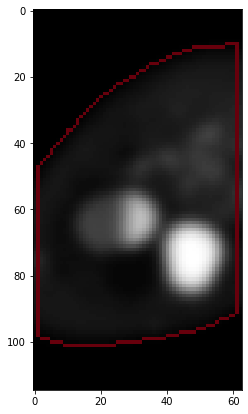

In [24]:
#@title Segment the cell (or the nucleus) { display-mode: "form" }
#@markdown *Click on the arrow to segment the entire cell (or nucleus) that is used as a reference for acquisition photobleaching.*
#@markdown **When analyzing *in vitro* data, set the threshold as low as possible to segment the full image**
intensity_threshold = 0.025 #@param {type:"raw"}
#@markdown  - Specify a threshold for segmentation (a larger value corresponds to a more stringent segmentation)
exp.segment_cell(thr_nuc=intensity_threshold)
plot_mask(exp.bleach_img,exp.nucmask)

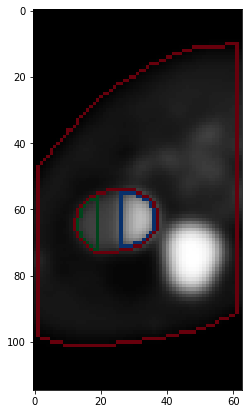

In [25]:
#@title Segment the half-bleached structure of interest
#@markdown *Click on the arrow to segment the structure of interest and to select the bleached one. **First specify the following parameters:** .*
intensity_threshold = 1 #@param {type:"raw"}
#@markdown  - Specify a scaling scaling factor to determine the intensity threshold for nuclear segmentation (a larger value corresponds to a more stringent segmentation)
bleach_threshold = 0.9 #@param {type:"raw"}
#@markdown  - Specify a scaling factor to segment the bleached structure of interest
bleach_depth = 0.9 #@param {type:"raw"}
#@markdown  - Specify a scaling factor to separate the bleached from the non-bleached half
extra_pixels = 2 #@param {type:"raw"}
#@markdown - specify the number of pixels between the bleached and the non-bleached half that are not considered for the analysis
exp.segment_condensate(thr_cond=intensity_threshold)
exp.getBleachedmask(alpha=bleach_threshold,sigma_b=1,beta=0.995,extra_pix=3)
plot_mask(exp.bleach_img,exp.nucmask,exp.bleachmask,exp.nonbleachmask)

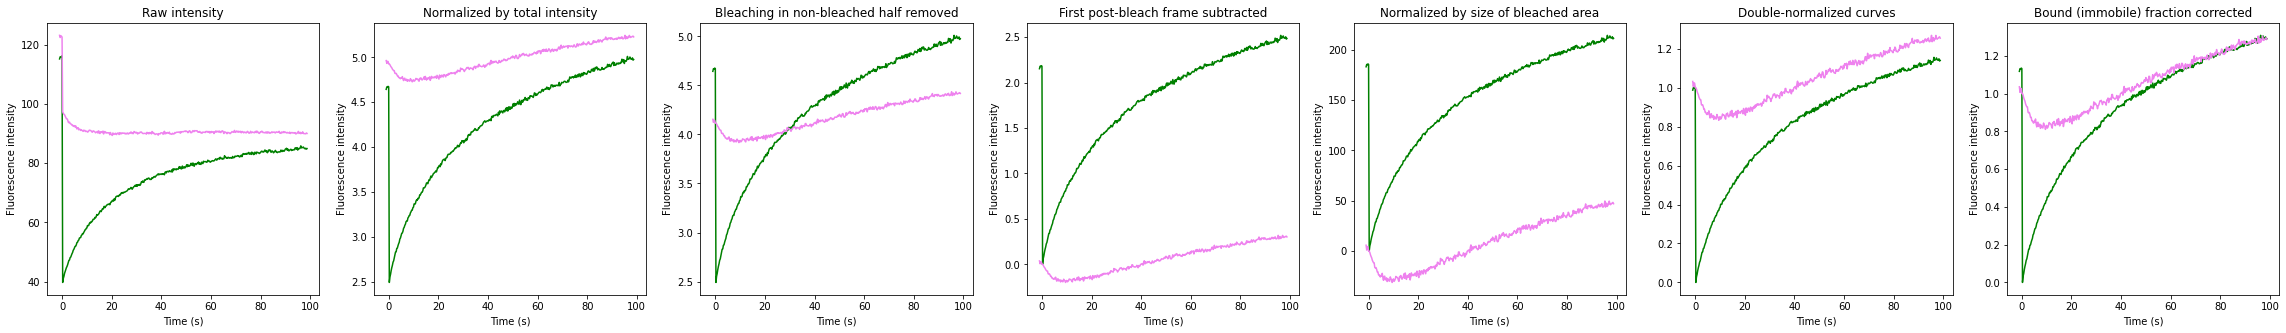

In [26]:
#@title Calculate normalized half-FRAP curves { display-mode: "form" }
#@markdown *Click on the arrow to retrieve the raw intensities in both halves and to perform the corresponding normalization*
Normalize_by_total_intensity=True #@param {type:"boolean"}
#@markdown  - Specify if total intensity will be used for normalization
exp.getIntensities()
exp.getNormalizedTraces(byTotal=Normalize_by_total_intensity)
exp.plotNormalizationProcess()

In [ ]:
#@title Save normalized half-FRAP curves { display-mode: "form" }
#@markdown *Click on the arrow to confirm the name of the .csv file that will be downloaded to your computer.*
name = "example_2" #@param {type:"raw"}
#@markdown  - Specify the name of the data set
exp.saveData(name)
files.download("%s.csv"%name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Remove data to continue the analysis { display-mode: "form" }
#@markdown *Click on the arrow to delete the current data set before uploading/analyzing the next one*
!rm -r *

## **Part II: Analysis of dataset with normalized curves**
*After having analyzed the individual experiments using the code above, use the steps below to upload the respective csv files (containing analyzed replicates for the same condition) to average them, determine the dip depth, and test if molecules undergo LLPS or ICBS*.

In [ ]:
#@title Load .csv files containing individual replicates { display-mode: "form" }
#@markdown *Click on the arrow to select all the .csv files that contain replicates analyzed according to the steps indicated above*
uploaded = files.upload()
# check all files with .csv extension

In [ ]:
#@title Run analysis with the options below { display-mode: "form" }
#@markdown *Click on the arrow to run the analysis with the options below*
bound_fraction = False #@param {type:"boolean"}
#@markdown - Specify if the curves should be normalized by the bound (immobile) fraction
use_std = True #@param {type:"boolean"}
#@markdown - Specify if the standard deviation (true) or the standard error of the mean (false) should be plotted
filter_window = 21 #@param {type:"raw"}
#@markdown - Specify the window length for the Savitzky-Golay filter that is used to smooth the curve for the non-bleached half 
order_polynomial = 2 #@param {type:"raw"}
#@markdown - Specify the polynomial order for the Savitzky-Golay filter that is used to smooth the curve for the non-bleached half 

path = os.getcwd()
alldata=MOCHAdataset(path)    
alldata.getAverage(bound_fraction=bound_fraction)
alldata.makeNicePlot(std=use_std,sg_window=filter_window,poly_order = order_polynomial)
alldata.getEnergy()

In [ ]:
#@title Interpret the result { display-mode: "form" }
#@markdown *Click on the arrow to interpret the result*
print("FINAL REPORT:")
if alldata.pvalue <= 0.01:
  print("The dip depth of the sample was significantly higher than the dip depth expected for freely diffusing molecules (p<0.01)")
  print("This indicates that the molecules of interest feel a barrier at the interface of the structure of interest, which is a hallmark of LLPS.")
  print("By using the calibration curve from Muzzopappa et al. 2022, the energy barrier determined from the dip depth is %s kT"%alldata.EnergyBarrier)
else:
  print("The dip depth (%s) is not significantly larger than the dip depth seen for freely diffusing molecules."%alldata.dip)
  print("This indicates that the molecules of interest do not feel any barrier at the interface of the structure of interest, indicating that molecules undergo ICBS.")


